# Creating annomaly plots with interannual variability between months for temperature, sea-ice, nutrietns, density and phytoplankton production! 

In [11]:
import warnings

warnings.simplefilter("ignore") # Silence warnings
import glob
from copy import deepcopy
import matplotlib
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pylab
import xarray as xr
#from cartopy.util import add_cyclic_point
from matplotlib.pyplot import figure
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset as NetCDFFile

plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict

import cmocean
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [12]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [13]:
import re

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [14]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

### Temperature 

In [20]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [21]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

In [22]:
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,149:170,233:270], axis = (2,3))

## Anomaly is monthly climatology minus the average climatology from the whole time period. 

In [23]:
temp_ao_anom = temp_ao-np.nanmean(temp_ao,axis=0)
temp_cs_anom = temp_cs-np.nanmean(temp_cs,axis=0)
temp_bs_anom = temp_bs-np.nanmean(temp_bs,axis=0)
temp_ca_anom = temp_ca-np.nanmean(temp_ca,axis=0)
temp_bb_anom = temp_bb-np.nanmean(temp_bb,axis=0)
temp_ess_anom = temp_ess-np.nanmean(temp_ess,axis=0)
temp_ls_anom = temp_ls-np.nanmean(temp_ls,axis=0)
temp_ns_anom = temp_ns-np.nanmean(temp_ns,axis=0)
temp_bts_anom =temp_bts-np.nanmean(temp_bts,axis=0)
temp_ks_anom = temp_ks-np.nanmean(temp_ks,axis=0)

# This is the error on the observations
err_ao = np.nanstd(temp_ao_anom,axis=(0,1))
err_cs = np.nanstd(temp_cs_anom,axis=(0,1))
err_bs = np.nanstd(temp_bs_anom,axis=(0,1))
err_ca = np.nanstd(temp_ca_anom,axis=(0,1))
err_bb = np.nanstd(temp_bb_anom,axis=(0,1))
err_ess = np.nanstd(temp_ess_anom,axis=(0,1))
err_ls = np.nanstd(temp_ls_anom,axis=(0,1))
err_ns = np.nanstd(temp_ns_anom,axis=(0,1))
err_bts = np.nanstd(temp_bts_anom,axis=(0,1))
err_ks = np.nanstd(temp_ks_anom,axis=(0,1))

In [24]:
cold_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) < -(err_ao/3))
warm_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) > (err_ao/3))

In [25]:
warm_years_ao

(array([ 3,  5, 13, 46, 47, 51, 53, 54, 57, 58, 59, 60]),)

In [26]:
err_ao

0.1728841268410591

In [27]:
cold_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) < 0)
cold_years_cs = np.where(np.nanmean(temp_cs_anom,axis=1) < 0)
cold_years_bs = np.where(np.nanmean(temp_bs_anom,axis=1) < 0)
cold_years_ca = np.where(np.nanmean(temp_ca_anom,axis=1) < 0)
cold_years_bb = np.where(np.nanmean(temp_bb_anom,axis=1) < 0)
cold_years_ess = np.where(np.nanmean(temp_ess_anom,axis=1) < 0)
cold_years_ls = np.where(np.nanmean(temp_ls_anom,axis=1) < 0)
cold_years_ns = np.where(np.nanmean(temp_ns_anom,axis=1) < 0)
cold_years_bts = np.where(np.nanmean(temp_bts_anom,axis=1) < 0)
cold_years_ks = np.where(np.nanmean(temp_ks_anom,axis=1) < 0)

warm_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) > 0)
warm_years_cs = np.where(np.nanmean(temp_cs_anom,axis=1) > 0)
warm_years_bs = np.where(np.nanmean(temp_bs_anom,axis=1) > 0)
warm_years_ca = np.where(np.nanmean(temp_ca_anom,axis=1) > 0)
warm_years_bb = np.where(np.nanmean(temp_bb_anom,axis=1) > 0)
warm_years_ess = np.where(np.nanmean(temp_ess_anom,axis=1) > 0)
warm_years_ls = np.where(np.nanmean(temp_ls_anom,axis=1) > 0)
warm_years_ns = np.where(np.nanmean(temp_ns_anom,axis=1) > 0)
warm_years_bts = np.where(np.nanmean(temp_bts_anom,axis=1) > 0)
warm_years_ks = np.where(np.nanmean(temp_ks_anom,axis=1) > 0)

[]

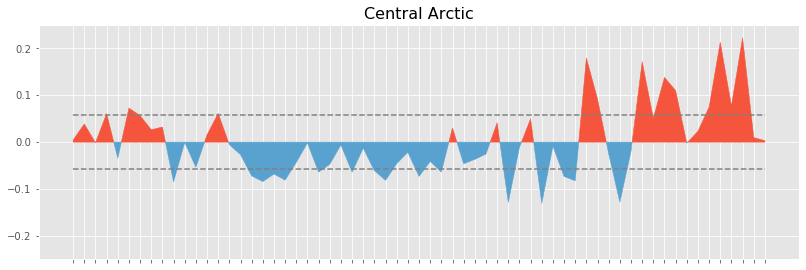

In [13]:
plt.style.use('ggplot')

years = ['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

# Subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ao/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ao/3, 0, 62,color='gray',linestyles='dashed')
ax1.set_title('Central Arctic', fontsize=16)
ax1.set_ylim(-0.25,0.25);
ax1.set_xticklabels('')

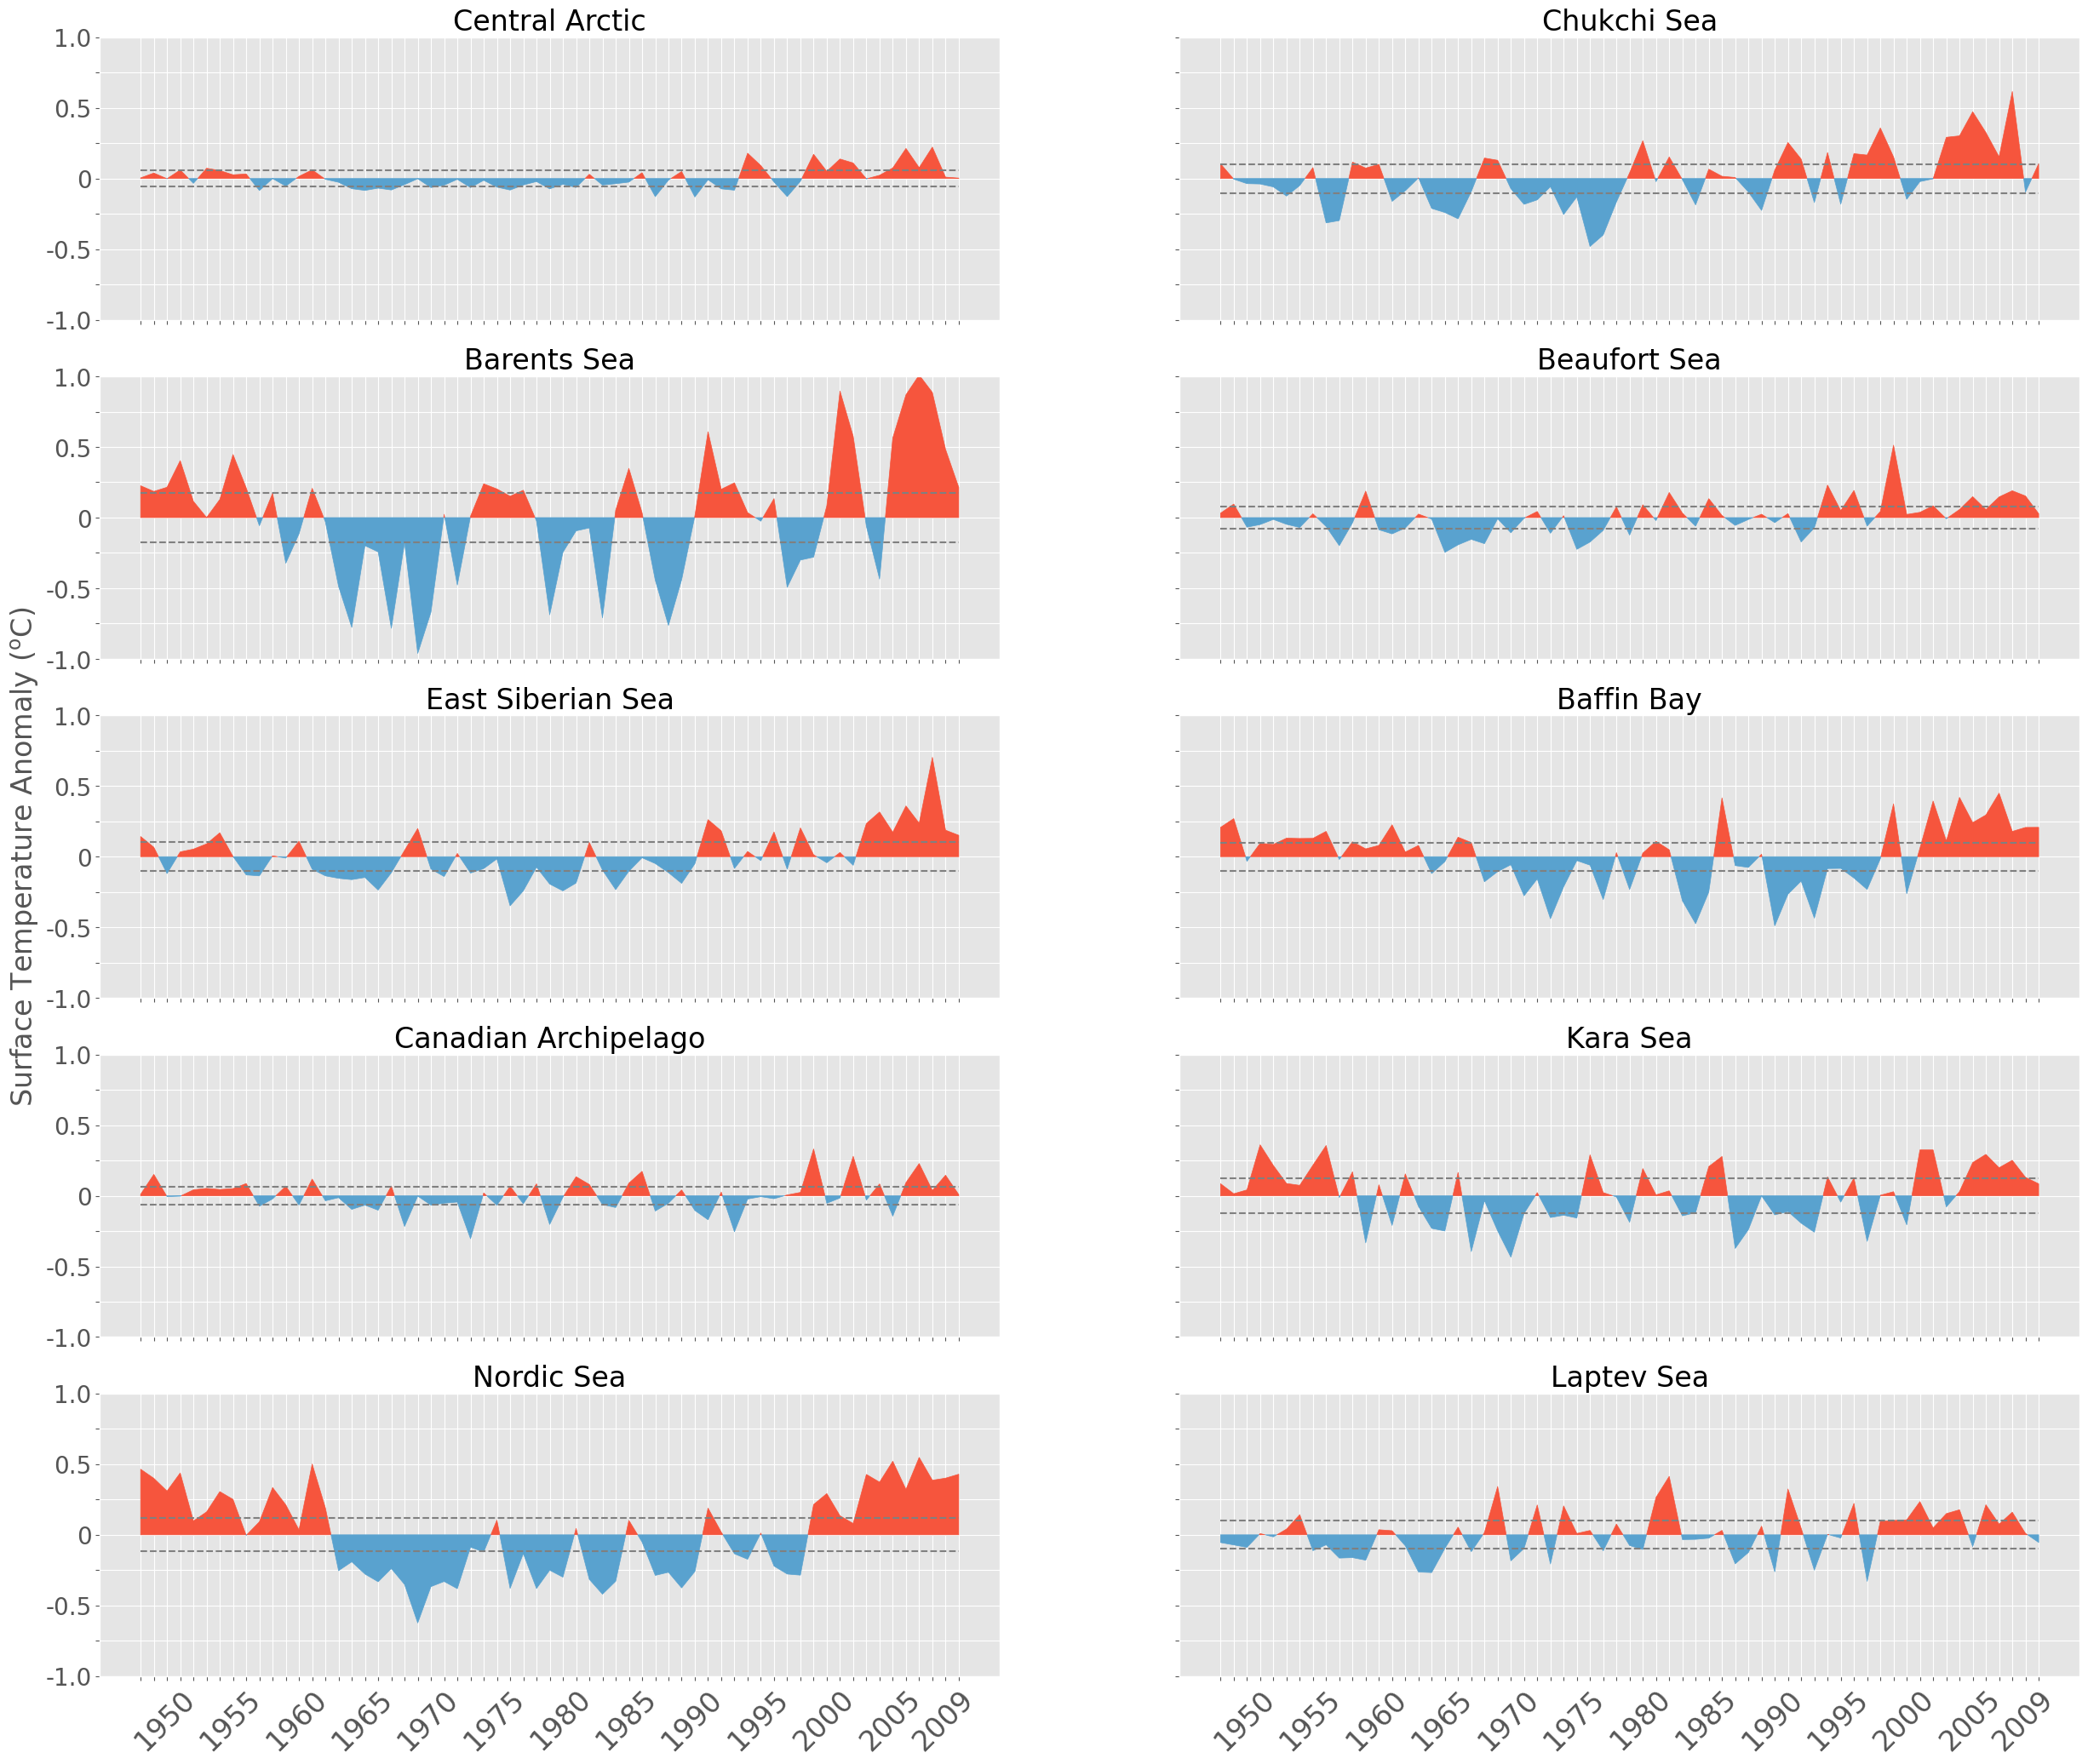

In [28]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ao/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ao/3, 0, 62,color='gray',linestyles='dashed')
ax1.set_title('Central Arctic', fontsize=24); 
ax1.set_ylim(-1,1); ax1.set_yticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'],fontsize=20);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_bts/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_bts/3, 0, 62,color='gray',linestyles='dashed')
ax2.set_title('Barents Sea', fontsize=24); 
ax2.set_ylim(-1,1); ax2.set_yticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'],fontsize=20);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_cs/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_cs/3, 0, 62,color='gray',linestyles='dashed')
ax3.set_title('Chukchi Sea', fontsize=24)
ax3.set_ylim(-1,1);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ess/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ess/3, 0, 62,color='gray',linestyles='dashed')
ax4.set_ylabel('Surface Temperature Anomaly ($^o$C)', fontsize=24)
ax4.set_title('East Siberian Sea', fontsize=24); 
ax4.set_ylim(-1,1); ax4.set_yticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'],fontsize=20);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ca/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ca/3, 0, 62,color='gray',linestyles='dashed')
ax5.set_title('Canadian Archipelago', fontsize=24); 
ax5.set_ylim(-1,1); ax5.set_yticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'],fontsize=20);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ns/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ns/3, 0, 62,color='gray',linestyles='dashed')
ax6.set_title('Nordic Sea', fontsize=24); 
ax6.set_ylim(-1,1); ax6.set_yticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'],fontsize=20);
ax6.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=24)
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_bs/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_bs/3, 0, 62,color='gray',linestyles='dashed')
ax7.set_title('Beaufort Sea', fontsize=24)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-1,1);

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_bb/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_bb/3, 0, 62,color='gray',linestyles='dashed')
ax8.set_title('Baffin Bay', fontsize=24)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-1,1);

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ks/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ks/3, 0, 62,color='gray',linestyles='dashed')
ax9.set_title('Kara Sea', fontsize=24)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-1,1);

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
plt.hlines(err_ls/3, 0, 62,color='gray',linestyles='dashed')
plt.hlines(-err_ls/3, 0, 62,color='gray',linestyles='dashed')
ax.set_title('Laptev Sea', fontsize=24);
ax.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=24)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_ylim(-1,1);  ax.set_yticklabels(''); 
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MARBL_SPECTRA_temp_anomaly',dpi=600, bbox_inches='tight')

plt.show()

### photoC_total

In [12]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_photoC_TOT*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
ds.photoC_TOT.shape

(756, 15, 180, 360)

In [14]:
photoC_TOT_ds_inter = np.empty([63,12,15,180,360])
photoC_TOT_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    photoC_TOT_ds_inter[i,:,:,:,:] = ds.photoC_TOT[x[i]:x[i]+12,:,:,:]

In [15]:
photoC_TOT_ao = np.nanmean(photoC_TOT_ds_inter[:,:,0,170:180,:], axis=(2,3))
photoC_TOT_cs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
photoC_TOT_bs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
photoC_TOT_ca = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
photoC_TOT_bb = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
photoC_TOT_ess = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
photoC_TOT_ls = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
photoC_TOT_ns = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
photoC_TOT_bts =np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
photoC_TOT_ks = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

In [16]:
photoC_TOT_ao_anom = photoC_TOT_ao-np.nanmean(photoC_TOT_ao,axis=0)
photoC_TOT_cs_anom = photoC_TOT_cs-np.nanmean(photoC_TOT_cs,axis=0)
photoC_TOT_bs_anom = photoC_TOT_bs-np.nanmean(photoC_TOT_bs,axis=0)
photoC_TOT_ca_anom = photoC_TOT_ca-np.nanmean(photoC_TOT_ca,axis=0)
photoC_TOT_bb_anom = photoC_TOT_bb-np.nanmean(photoC_TOT_bb,axis=0)
photoC_TOT_ess_anom = photoC_TOT_ess-np.nanmean(photoC_TOT_ess,axis=0)
photoC_TOT_ls_anom = photoC_TOT_ls-np.nanmean(photoC_TOT_ls,axis=0)
photoC_TOT_ns_anom = photoC_TOT_ns-np.nanmean(photoC_TOT_ns,axis=0)
photoC_TOT_bts_anom =photoC_TOT_bts-np.nanmean(photoC_TOT_bts,axis=0)
photoC_TOT_ks_anom = photoC_TOT_ks-np.nanmean(photoC_TOT_ks,axis=0)

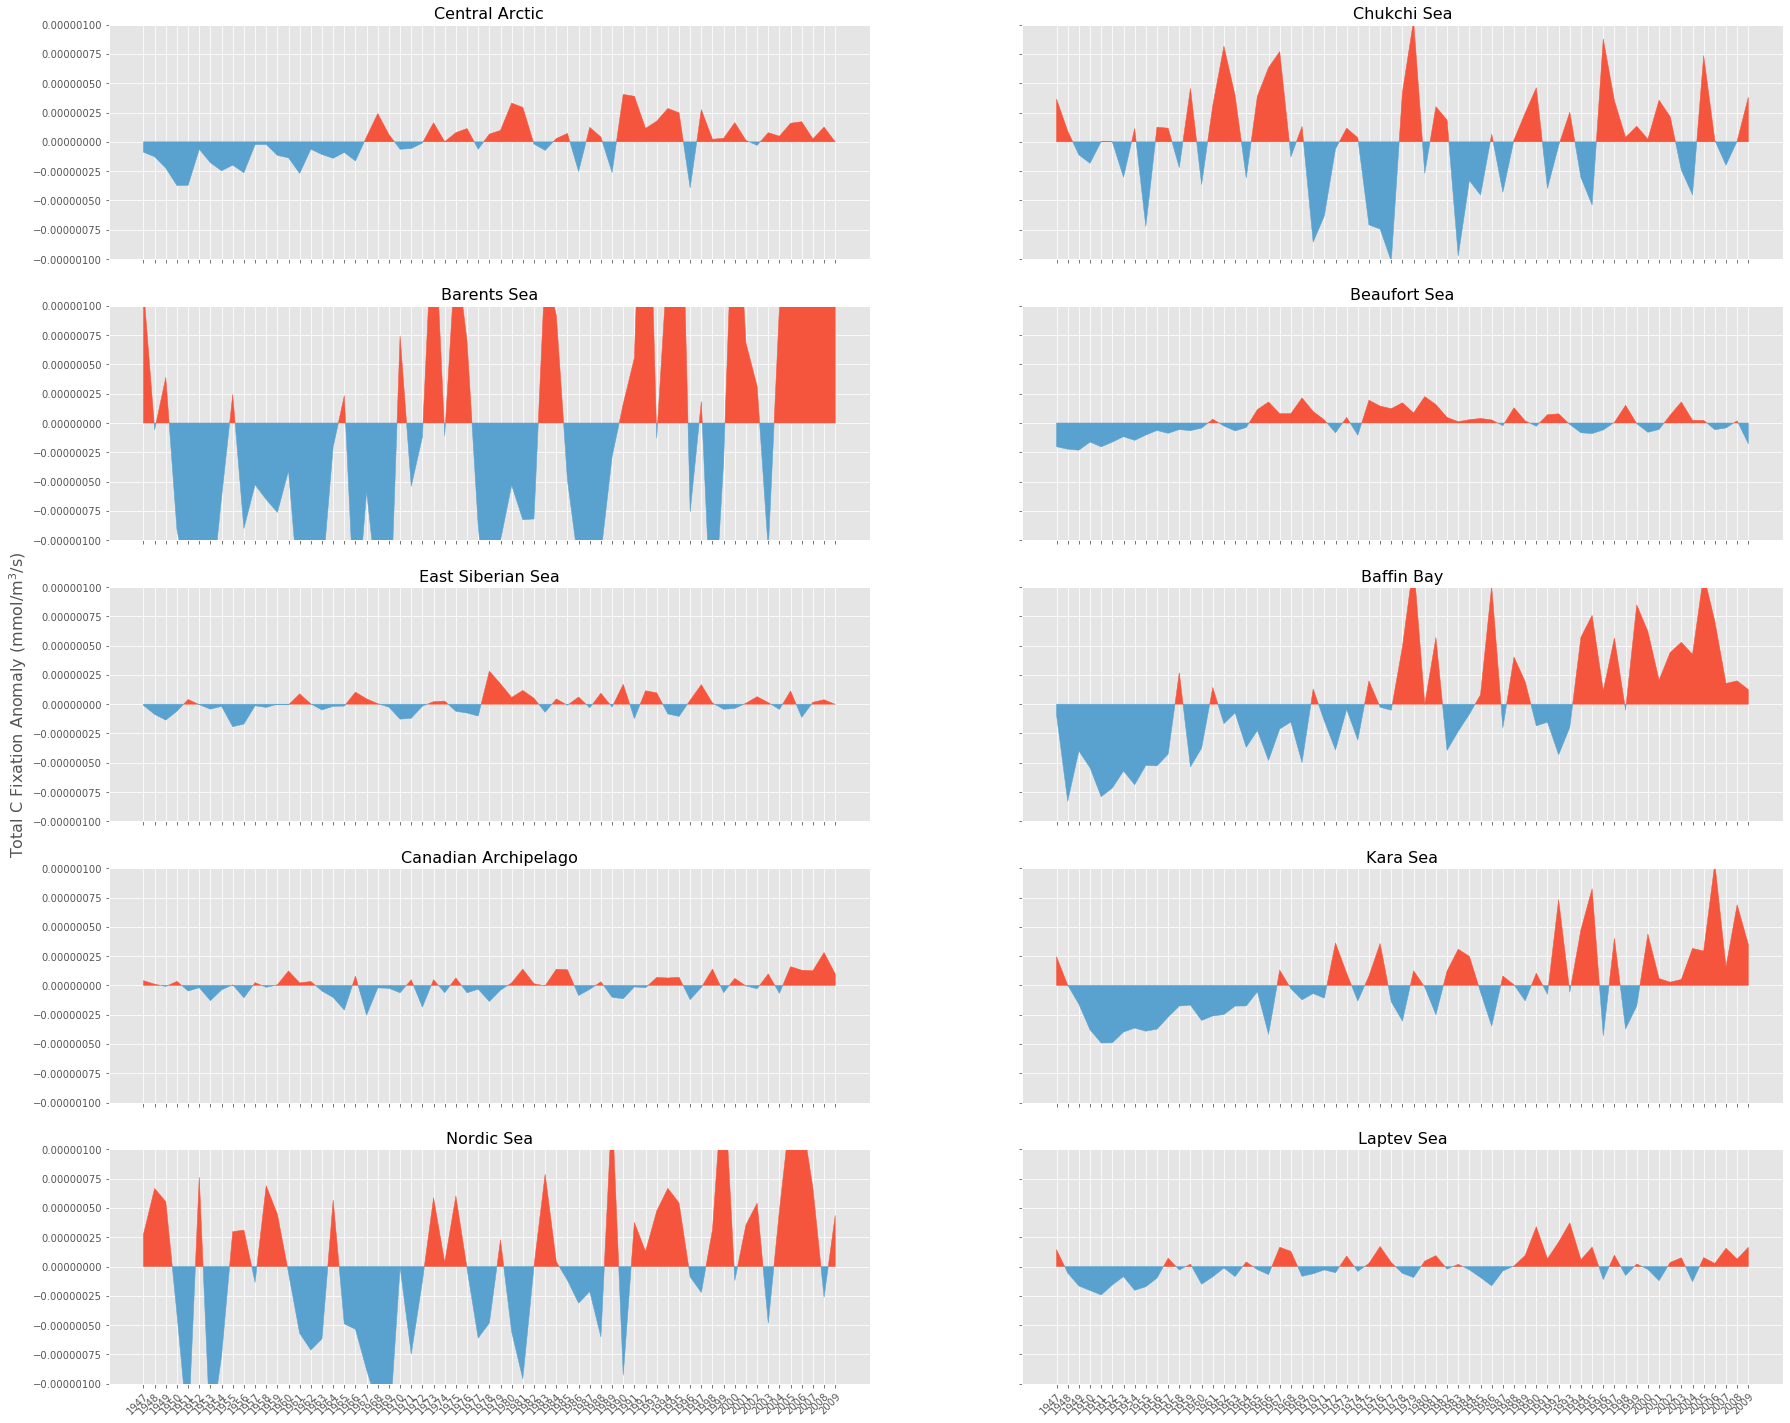

In [17]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(photoC_TOT_ao_anom,axis=1), where=np.nanmean(photoC_TOT_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(photoC_TOT_ao_anom,axis=1), where=np.nanmean(photoC_TOT_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16)

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(photoC_TOT_bts_anom,axis=1), where=np.nanmean(photoC_TOT_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(photoC_TOT_bts_anom,axis=1), where=np.nanmean(photoC_TOT_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16)

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(photoC_TOT_cs_anom,axis=1), where=np.nanmean(photoC_TOT_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(photoC_TOT_cs_anom,axis=1), where=np.nanmean(photoC_TOT_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(photoC_TOT_ess_anom,axis=1), where=np.nanmean(photoC_TOT_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(photoC_TOT_ess_anom,axis=1), where=np.nanmean(photoC_TOT_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_title('East Siberian Sea', fontsize=16)

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(photoC_TOT_ca_anom,axis=1), where=np.nanmean(photoC_TOT_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(photoC_TOT_ca_anom,axis=1), where=np.nanmean(photoC_TOT_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16)

ax6 = fig.add_subplot(gs[4, 0])
ax6.fill_between(years, np.nanmean(photoC_TOT_ns_anom,axis=1), where=np.nanmean(photoC_TOT_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(photoC_TOT_ns_anom,axis=1), where=np.nanmean(photoC_TOT_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16)
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(photoC_TOT_bs_anom,axis=1), where=np.nanmean(photoC_TOT_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(photoC_TOT_bs_anom,axis=1), where=np.nanmean(photoC_TOT_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(photoC_TOT_bb_anom,axis=1), where=np.nanmean(photoC_TOT_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(photoC_TOT_bb_anom,axis=1), where=np.nanmean(photoC_TOT_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(photoC_TOT_ks_anom,axis=1), where=np.nanmean(photoC_TOT_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(photoC_TOT_ks_anom,axis=1), where=np.nanmean(photoC_TOT_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(photoC_TOT_ls_anom,axis=1), where=np.nanmean(photoC_TOT_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(photoC_TOT_ls_anom,axis=1), where=np.nanmean(photoC_TOT_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Basics 
ax4.set_ylabel('Total C Fixation Anomaly (mmol/m$^3$/s)', fontsize=16)
ax1.set_ylim(-10e-7,10e-7); ax1.set_xticklabels('')
ax2.set_ylim(-10e-7,10e-7); ax2.set_xticklabels('')
ax3.set_ylim(-10e-7,10e-7); ax3.set_yticklabels(''); ax3.set_xticklabels('')
ax4.set_ylim(-10e-7,10e-7); ax4.set_xticklabels('')
ax5.set_ylim(-10e-7,10e-7); ax5.set_xticklabels('')
ax6.set_ylim(-10e-7,10e-7);
ax7.set_ylim(-10e-7,10e-7); ax7.set_yticklabels(''); ax7.set_xticklabels('')
ax8.set_ylim(-10e-7,10e-7); ax8.set_yticklabels(''); ax8.set_xticklabels('')
ax9.set_ylim(-10e-7,10e-7); ax9.set_yticklabels(''); ax9.set_xticklabels('')
ax.set_ylim(-10e-7,10e-7);  ax.set_yticklabels(''); 

# Save Figure 
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MARBL_SPECTRA_photoC_TOT_anomaly',dpi=600, bbox_inches='tight')
plt.show()

### Sea-ICE

In [29]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [30]:
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [31]:
ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,170:180,:], axis=(2,3))
ECOSYS_IFRAC_cs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,0:25], axis = (2,3))
ECOSYS_IFRAC_bs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,25:55], axis = (2,3))
ECOSYS_IFRAC_ca = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,55:110], axis = (2,3))
ECOSYS_IFRAC_bb = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,110:135], axis = (2,3))
ECOSYS_IFRAC_ess = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,325:360], axis = (2,3))
ECOSYS_IFRAC_ls = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,270:325], axis = (2,3))
ECOSYS_IFRAC_ns = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,155:205], axis = (2,3))
ECOSYS_IFRAC_bts =np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,205:233], axis = (2,3))
ECOSYS_IFRAC_ks = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,233:270], axis = (2,3))

In [32]:
ECOSYS_IFRAC_ao_anom = ECOSYS_IFRAC_ao-np.nanmean(ECOSYS_IFRAC_ao,axis=0)
ECOSYS_IFRAC_cs_anom = ECOSYS_IFRAC_cs-np.nanmean(ECOSYS_IFRAC_cs,axis=0)
ECOSYS_IFRAC_bs_anom = ECOSYS_IFRAC_bs-np.nanmean(ECOSYS_IFRAC_bs,axis=0)
ECOSYS_IFRAC_ca_anom = ECOSYS_IFRAC_ca-np.nanmean(ECOSYS_IFRAC_ca,axis=0)
ECOSYS_IFRAC_bb_anom = ECOSYS_IFRAC_bb-np.nanmean(ECOSYS_IFRAC_bb,axis=0)
ECOSYS_IFRAC_ess_anom = ECOSYS_IFRAC_ess-np.nanmean(ECOSYS_IFRAC_ess,axis=0)
ECOSYS_IFRAC_ls_anom = ECOSYS_IFRAC_ls-np.nanmean(ECOSYS_IFRAC_ls,axis=0)
ECOSYS_IFRAC_ns_anom = ECOSYS_IFRAC_ns-np.nanmean(ECOSYS_IFRAC_ns,axis=0)
ECOSYS_IFRAC_bts_anom =ECOSYS_IFRAC_bts-np.nanmean(ECOSYS_IFRAC_bts,axis=0)
ECOSYS_IFRAC_ks_anom = ECOSYS_IFRAC_ks-np.nanmean(ECOSYS_IFRAC_ks,axis=0)

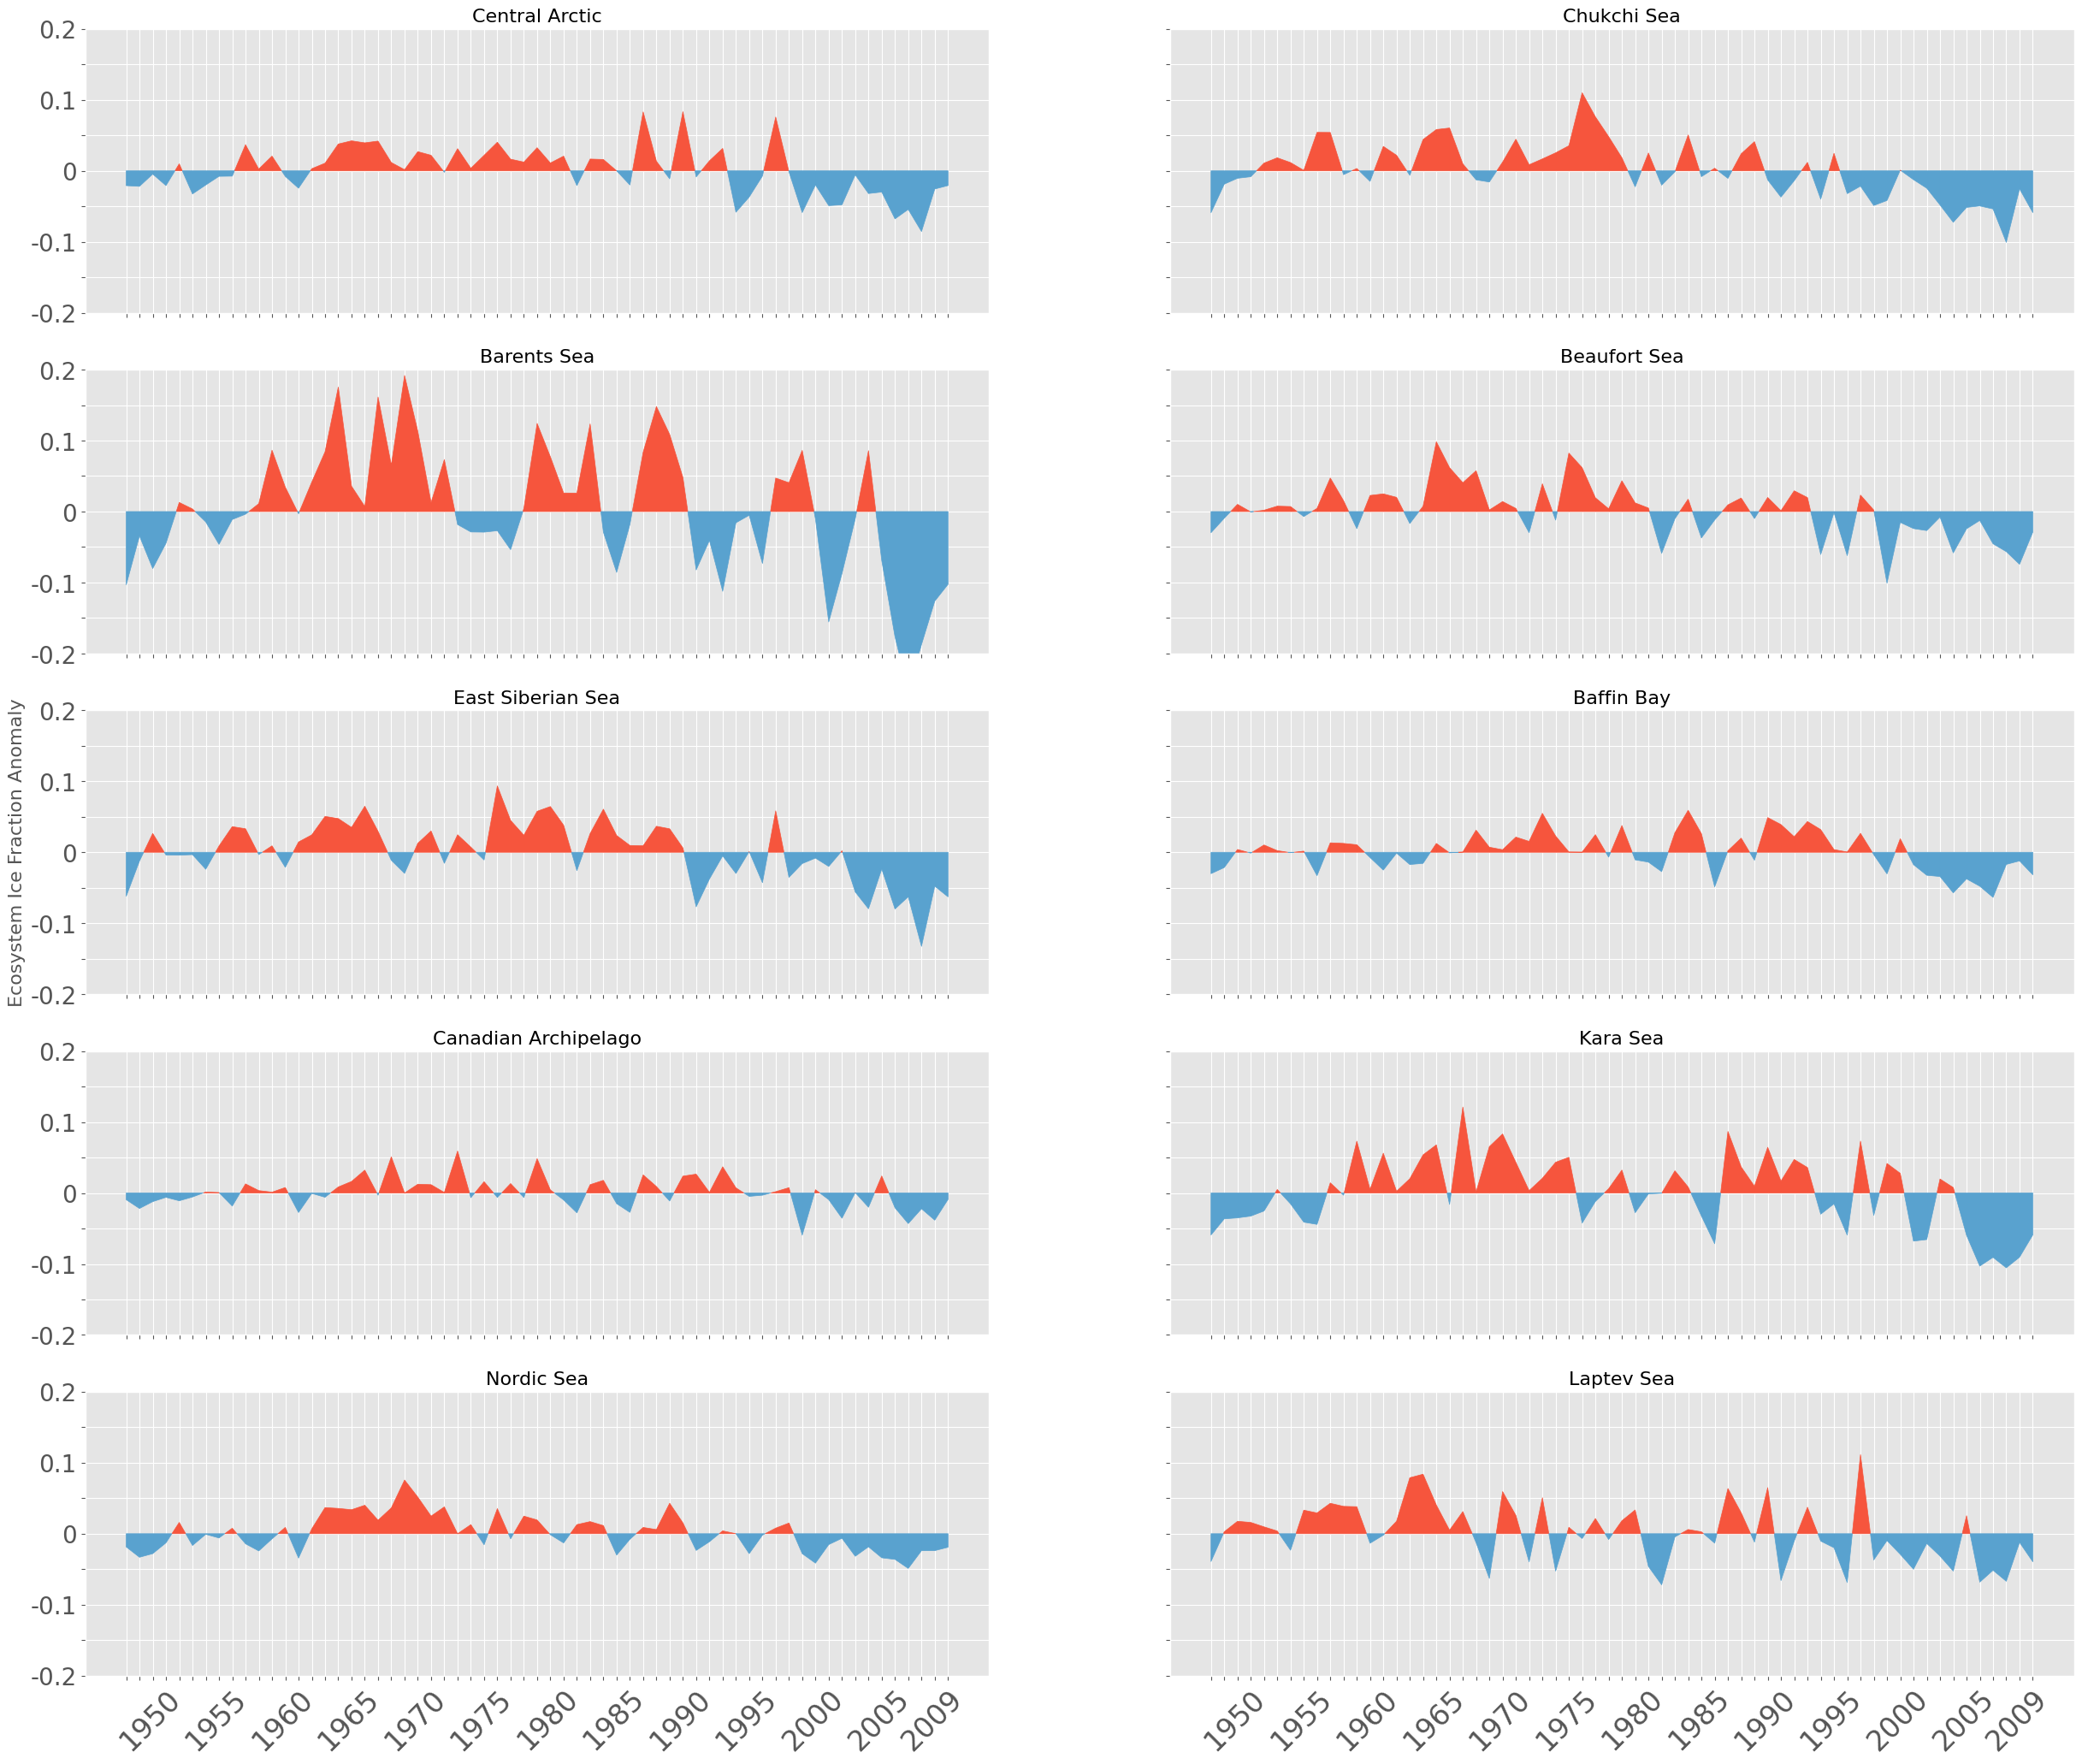

In [34]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16)

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(ECOSYS_IFRAC_bts_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(ECOSYS_IFRAC_bts_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16)

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(ECOSYS_IFRAC_cs_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(ECOSYS_IFRAC_cs_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(ECOSYS_IFRAC_ess_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(ECOSYS_IFRAC_ess_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_title('East Siberian Sea', fontsize=16)

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(ECOSYS_IFRAC_ca_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(ECOSYS_IFRAC_ca_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16)

ax6 = fig.add_subplot(gs[4, 0])
ax6.fill_between(years, np.nanmean(ECOSYS_IFRAC_ns_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(ECOSYS_IFRAC_ns_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16)
ax6.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=24)
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(ECOSYS_IFRAC_bs_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(ECOSYS_IFRAC_bs_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(ECOSYS_IFRAC_bb_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(ECOSYS_IFRAC_bb_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(ECOSYS_IFRAC_ks_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(ECOSYS_IFRAC_ks_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(ECOSYS_IFRAC_ls_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(ECOSYS_IFRAC_ls_anom,axis=1), where=np.nanmean(ECOSYS_IFRAC_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=24)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_ylim(-1,1);  ax.set_yticklabels(''); 

# Basics 
ax4.set_ylabel('Ecosystem Ice Fraction Anomaly', fontsize=16)
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_ylim(-.2,.2); ax3.set_yticklabels(''); ax3.set_xticklabels('')
ax4.set_xticklabels(''); ax5.set_xticklabels('')
ax6.set_ylim(-0.2,0.2); ax6.set_yticklabels(['-0.2','','-0.1','','0','','0.1','','0.2'],fontsize=20);
ax2.set_ylim(-0.2,0.2); ax2.set_yticklabels(['-0.2','','-0.1','','0','','0.1','','0.2'],fontsize=20);
ax1.set_ylim(-0.2,0.2); ax1.set_yticklabels(['-0.2','','-0.1','','0','','0.1','','0.2'],fontsize=20);
ax4.set_ylim(-0.2,0.2); ax4.set_yticklabels(['-0.2','','-0.1','','0','','0.1','','0.2'],fontsize=20);
ax5.set_ylim(-0.2,0.2); ax5.set_yticklabels(['-0.2','','-0.1','','0','','0.1','','0.2'],fontsize=20);
ax7.set_ylim(-.2,.2); ax7.set_yticklabels(''); ax7.set_xticklabels('')
ax8.set_ylim(-.2,.2); ax8.set_yticklabels(''); ax8.set_xticklabels('')
ax9.set_ylim(-.2,.2); ax9.set_yticklabels(''); ax9.set_xticklabels('')
ax.set_ylim(-.2,.2);  ax.set_yticklabels(''); 

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MARBL_SPECTRA_ECOSYS_IFRAC_anomaly',dpi=600, bbox_inches='tight')
plt.show()

## NO3

In [23]:
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [24]:
ds.NO3

<xarray.DataArray 'NO3' (time: 756, z_t: 60, lat: 180, lon: 360)>
dask.array<concatenate, shape=(756, 60, 180, 360), dtype=float32, chunksize=(12, 60, 180, 360)>
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0062-02-01 00:00:00 ... 0125-01-01 00:00:00
Attributes:
    long_name:     Dissolved Inorganic Nitrate
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [25]:
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

In [26]:
NO3_ao = np.nanmean(NO3_ds_inter[:,:,170:180,:], axis=(2,3))
NO3_cs = np.nanmean(NO3_ds_inter[:,:,149:170,0:25], axis = (2,3))
NO3_bs = np.nanmean(NO3_ds_inter[:,:,149:170,25:55], axis = (2,3))
NO3_ca = np.nanmean(NO3_ds_inter[:,:,149:170,55:110], axis = (2,3))
NO3_bb = np.nanmean(NO3_ds_inter[:,:,149:170,110:135], axis = (2,3))
NO3_ess = np.nanmean(NO3_ds_inter[:,:,149:170,325:360], axis = (2,3))
NO3_ls = np.nanmean(NO3_ds_inter[:,:,149:170,270:325], axis = (2,3))
NO3_ns = np.nanmean(NO3_ds_inter[:,:,149:170,155:205], axis = (2,3))
NO3_bts =np.nanmean(NO3_ds_inter[:,:,149:170,205:233], axis = (2,3))
NO3_ks = np.nanmean(NO3_ds_inter[:,:,149:170,233:270], axis = (2,3))

In [27]:
NO3_ao_anom = NO3_ao-np.nanmean(NO3_ao,axis=0)
NO3_cs_anom = NO3_cs-np.nanmean(NO3_cs,axis=0)
NO3_bs_anom = NO3_bs-np.nanmean(NO3_bs,axis=0)
NO3_ca_anom = NO3_ca-np.nanmean(NO3_ca,axis=0)
NO3_bb_anom = NO3_bb-np.nanmean(NO3_bb,axis=0)
NO3_ess_anom = NO3_ess-np.nanmean(NO3_ess,axis=0)
NO3_ls_anom = NO3_ls-np.nanmean(NO3_ls,axis=0)
NO3_ns_anom = NO3_ns-np.nanmean(NO3_ns,axis=0)
NO3_bts_anom =NO3_bts-np.nanmean(NO3_bts,axis=0)
NO3_ks_anom = NO3_ks-np.nanmean(NO3_ks,axis=0)

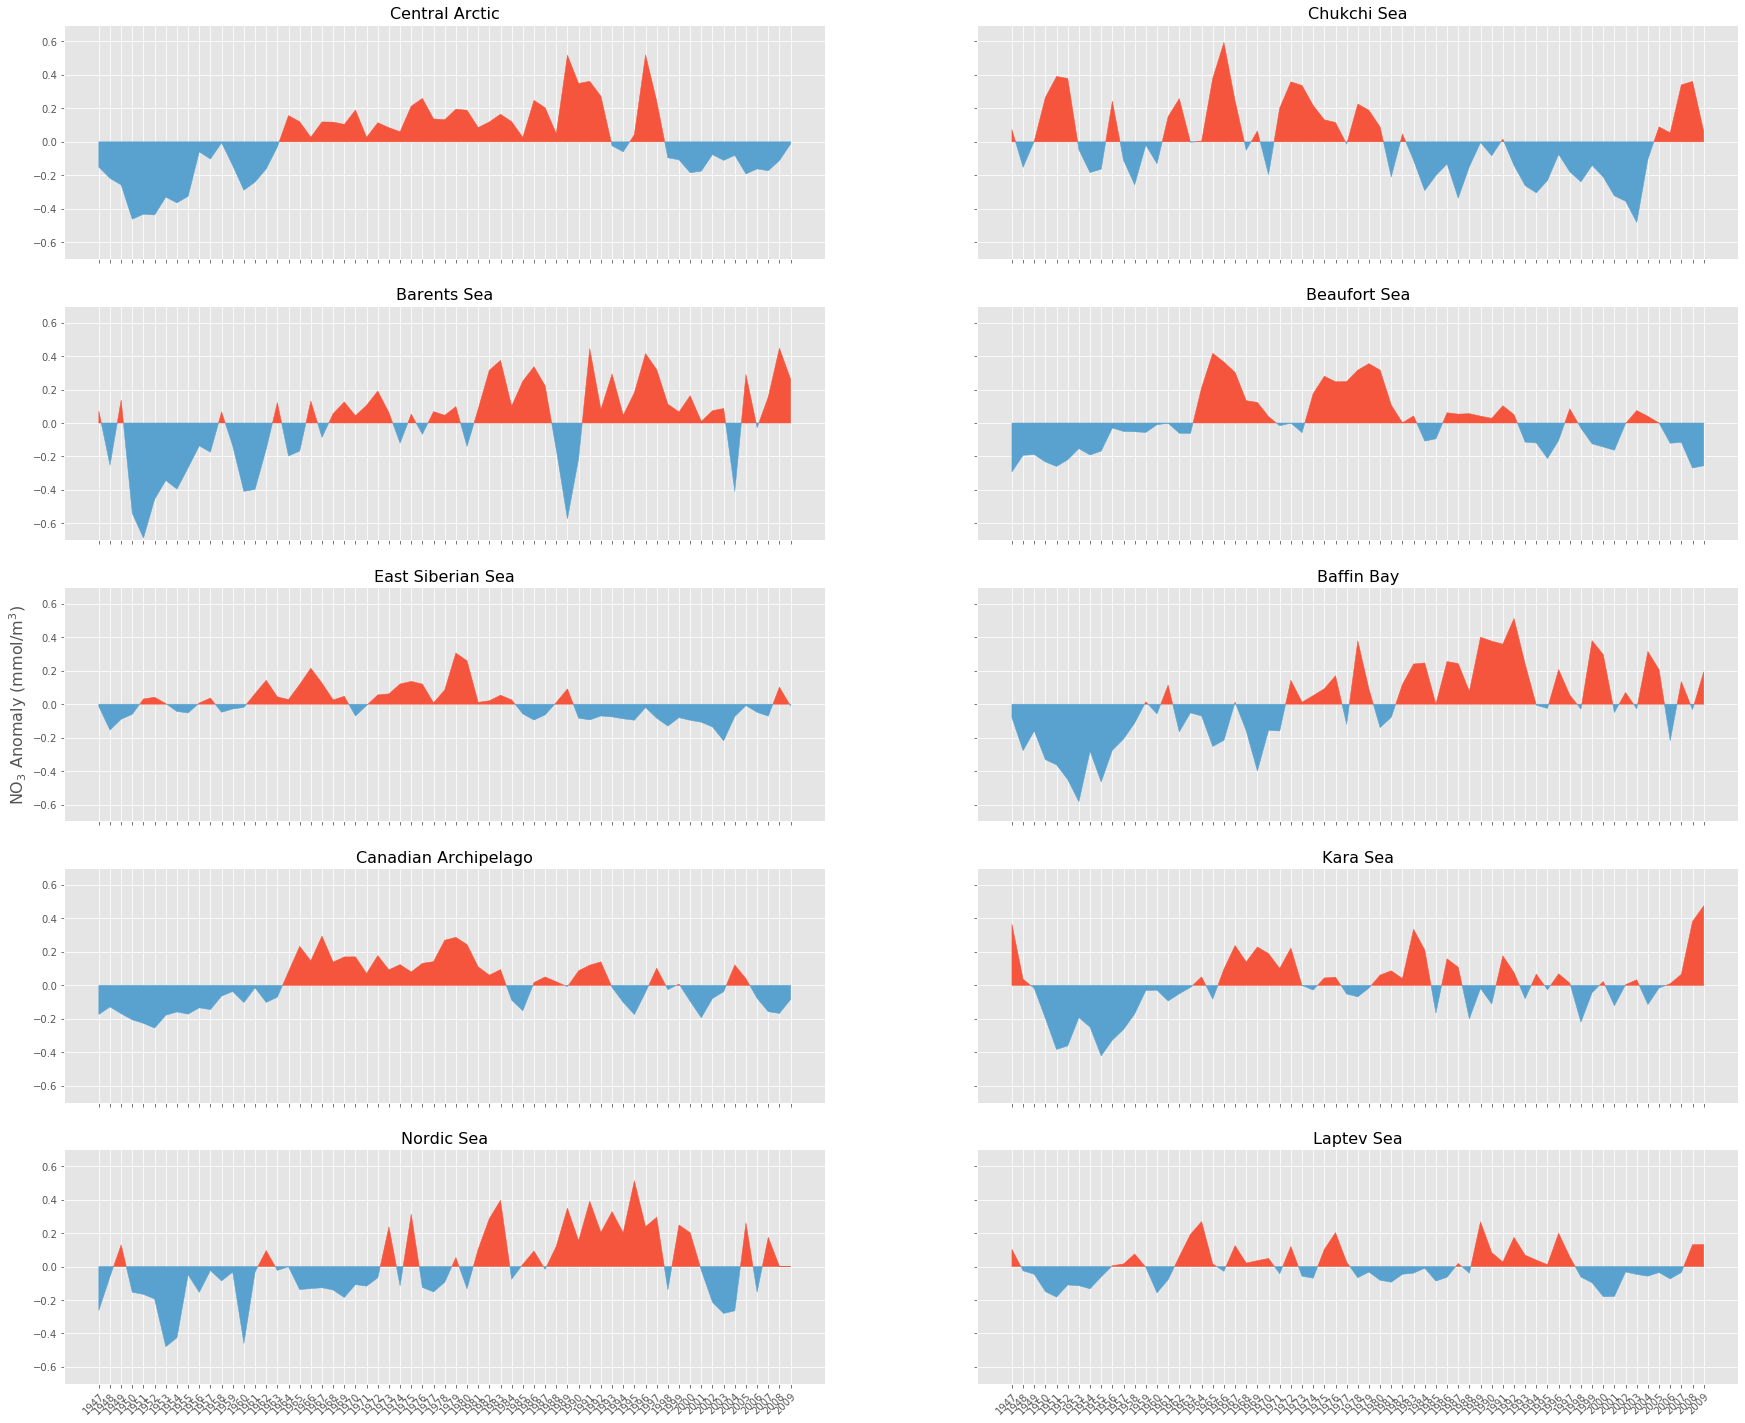

In [28]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(NO3_ao_anom,axis=1), where=np.nanmean(NO3_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(NO3_ao_anom,axis=1), where=np.nanmean(NO3_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16)

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(NO3_bts_anom,axis=1), where=np.nanmean(NO3_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(NO3_bts_anom,axis=1), where=np.nanmean(NO3_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16)

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(NO3_cs_anom,axis=1), where=np.nanmean(NO3_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(NO3_cs_anom,axis=1), where=np.nanmean(NO3_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(NO3_ess_anom,axis=1), where=np.nanmean(NO3_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(NO3_ess_anom,axis=1), where=np.nanmean(NO3_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_title('East Siberian Sea', fontsize=16)

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(NO3_ca_anom,axis=1), where=np.nanmean(NO3_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(NO3_ca_anom,axis=1), where=np.nanmean(NO3_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16)

ax6 = fig.add_subplot(gs[4, 0])
ax6.fill_between(years, np.nanmean(NO3_ns_anom,axis=1), where=np.nanmean(NO3_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(NO3_ns_anom,axis=1), where=np.nanmean(NO3_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16)
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(NO3_bs_anom,axis=1), where=np.nanmean(NO3_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(NO3_bs_anom,axis=1), where=np.nanmean(NO3_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(NO3_bb_anom,axis=1), where=np.nanmean(NO3_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(NO3_bb_anom,axis=1), where=np.nanmean(NO3_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(NO3_ks_anom,axis=1), where=np.nanmean(NO3_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(NO3_ks_anom,axis=1), where=np.nanmean(NO3_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(NO3_ls_anom,axis=1), where=np.nanmean(NO3_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(NO3_ls_anom,axis=1), where=np.nanmean(NO3_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Basics 
ax4.set_ylabel('NO$_3$ Anomaly (mmol/m$^3$)', fontsize=16)
ax1.set_ylim(-.7,.7); ax1.set_xticklabels('')
ax2.set_ylim(-.7,.7); ax2.set_xticklabels('')
ax3.set_ylim(-.7,.7); ax3.set_yticklabels(''); ax3.set_xticklabels('')
ax4.set_ylim(-.7,.7); ax4.set_xticklabels('')
ax5.set_ylim(-.7,.7); ax5.set_xticklabels('')
ax6.set_ylim(-.7,.7);
ax7.set_ylim(-.7,.7); ax7.set_yticklabels(''); ax7.set_xticklabels('')
ax8.set_ylim(-.7,.7); ax8.set_yticklabels(''); ax8.set_xticklabels('')
ax9.set_ylim(-.7,.7); ax9.set_yticklabels(''); ax9.set_xticklabels('')
ax.set_ylim(-.7,.7);  ax.set_yticklabels(''); 
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MARBL_SPECTRA_NO3_anomaly',dpi=600, bbox_inches='tight')

plt.show()

## Density (Rho- RHo22). 

In [29]:
RHO_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_RHO*.nc', recursive=True))
ds= xr.open_mfdataset(RHO_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [30]:
np.where((ds.z_t/100)>200)

(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59]),)

In [31]:
RHO_ds_inter = np.empty([63,12,60,180,360])
RHO_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    RHO_ds_inter[i,:,:,:,:] = ds.RHO[x[i]:x[i]+12,:,:,:]

## Create Stratification Array (RHO[0]-RHO[200])

In [32]:
STRAT = (RHO_ds_inter[:,:,0,:,:]-  RHO_ds_inter[:,:,19,:,:])/1000000 # g/cm^3 ---> g/m^3 
# Create maps, globally

In [33]:
STRAT.shape

(63, 12, 180, 360)

In [34]:
RHO_ao = np.nanmean(STRAT[:,:,170:180,:], axis=(2,3))
RHO_cs = np.nanmean(STRAT[:,:,149:170,0:25], axis = (2,3))
RHO_bs = np.nanmean(STRAT[:,:,149:170,25:55], axis = (2,3))
RHO_ca = np.nanmean(STRAT[:,:,149:170,55:110], axis = (2,3))
RHO_bb = np.nanmean(STRAT[:,:,149:170,110:135], axis = (2,3))
RHO_ess = np.nanmean(STRAT[:,:,149:170,325:360], axis = (2,3))
RHO_ls = np.nanmean(STRAT[:,:,149:170,270:325], axis = (2,3))
RHO_ns = np.nanmean(STRAT[:,:,149:170,155:205], axis = (2,3))
RHO_bts =np.nanmean(STRAT[:,:,149:170,205:233], axis = (2,3))
RHO_ks = np.nanmean(STRAT[:,:,149:170,233:270], axis = (2,3))

In [35]:
RHO_ao_anom = RHO_ao-np.nanmean(RHO_ao,axis=0)
RHO_cs_anom = RHO_cs-np.nanmean(RHO_cs,axis=0)
RHO_bs_anom = RHO_bs-np.nanmean(RHO_bs,axis=0)
RHO_ca_anom = RHO_ca-np.nanmean(RHO_ca,axis=0)
RHO_bb_anom = RHO_bb-np.nanmean(RHO_bb,axis=0)
RHO_ess_anom = RHO_ess-np.nanmean(RHO_ess,axis=0)
RHO_ls_anom = RHO_ls-np.nanmean(RHO_ls,axis=0)
RHO_ns_anom = RHO_ns-np.nanmean(RHO_ns,axis=0)
RHO_bts_anom = RHO_bts-np.nanmean(RHO_bts,axis=0)
RHO_ks_anom = RHO_ks-np.nanmean(RHO_ks,axis=0)

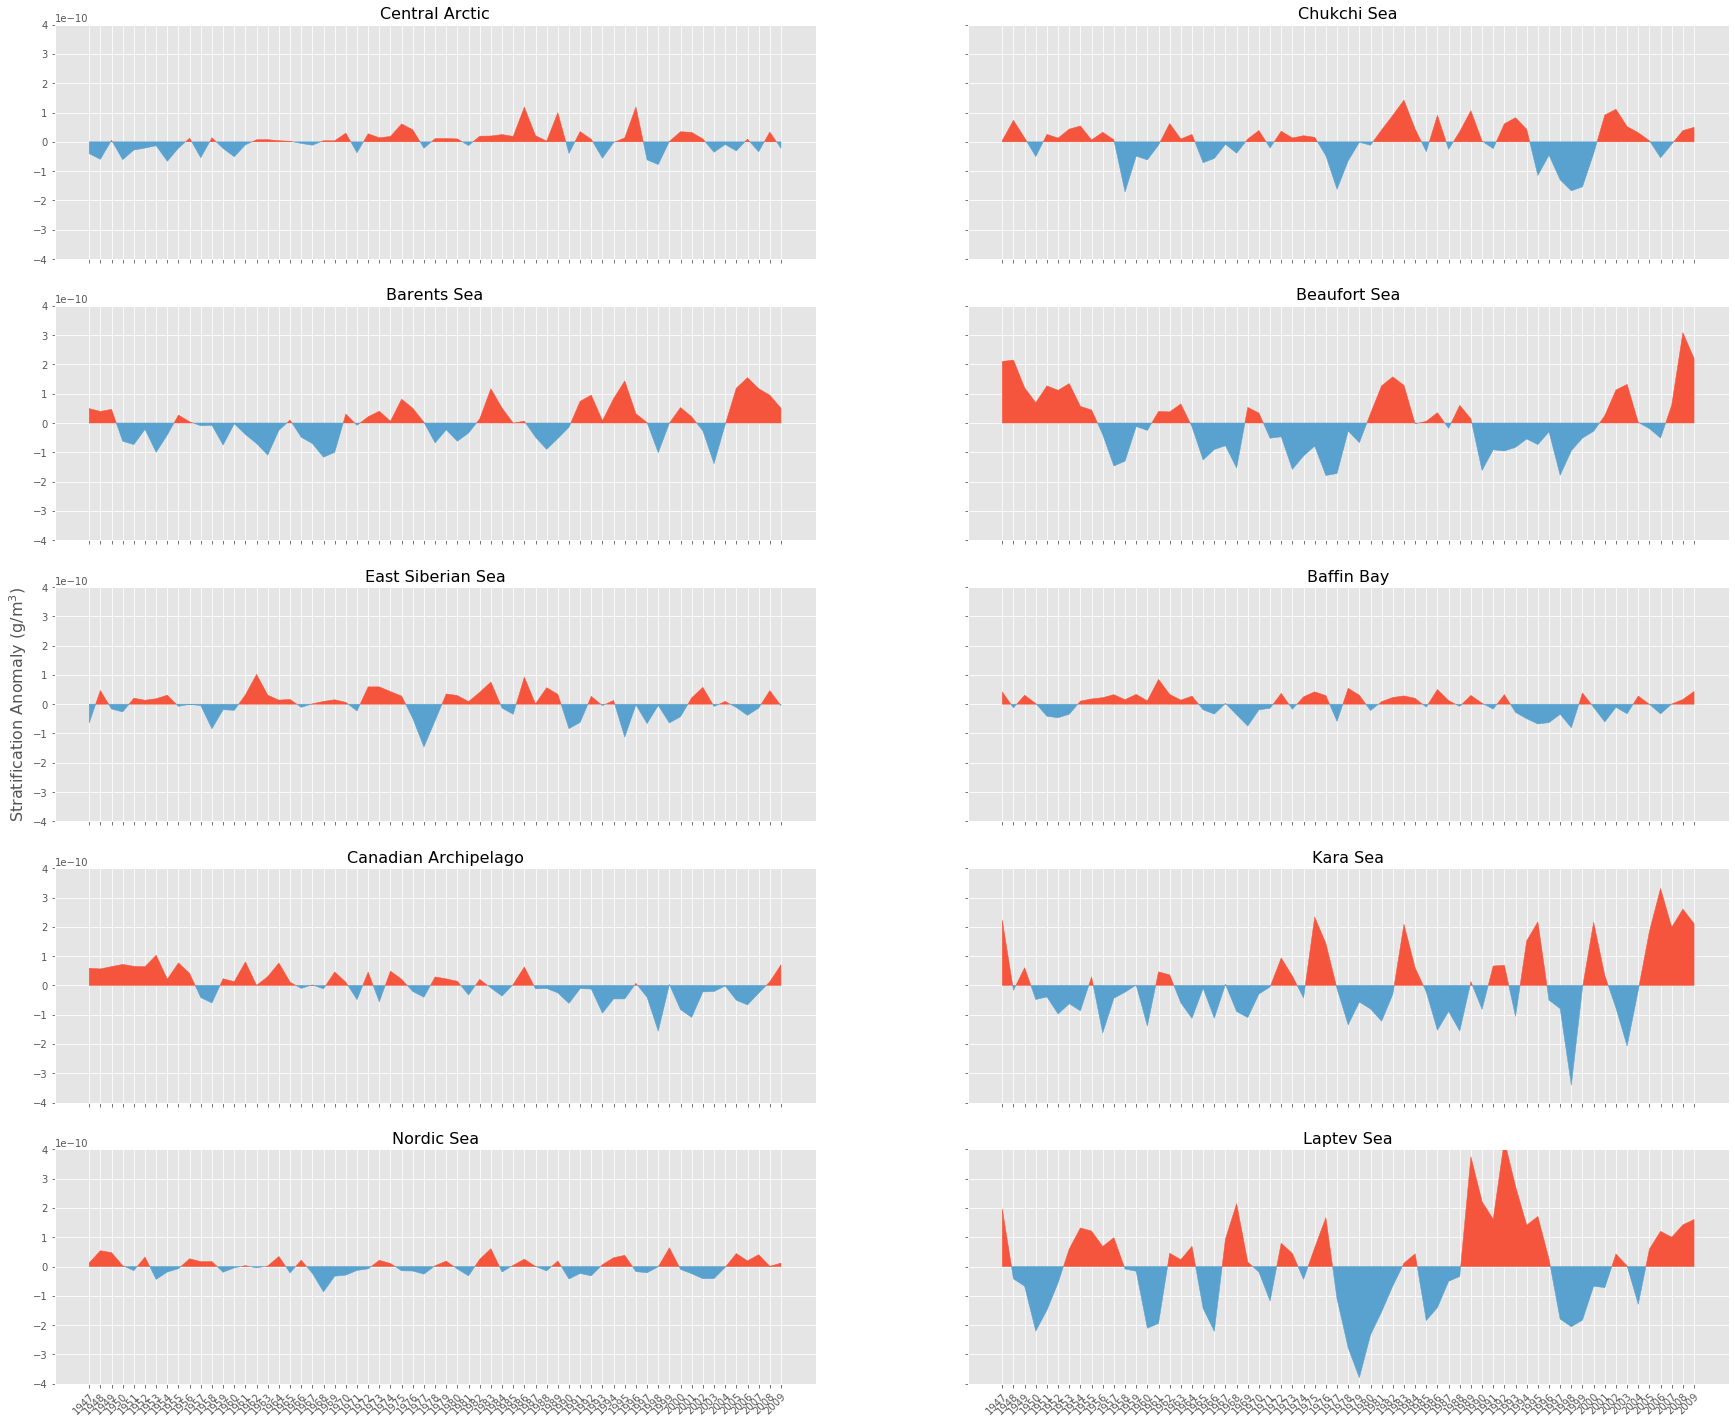

In [36]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(RHO_ao_anom,axis=1), where=np.nanmean(RHO_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(RHO_ao_anom,axis=1), where=np.nanmean(RHO_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16)

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(RHO_bts_anom,axis=1), where=np.nanmean(RHO_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(RHO_bts_anom,axis=1), where=np.nanmean(RHO_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16)

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(RHO_cs_anom,axis=1), where=np.nanmean(RHO_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(RHO_cs_anom,axis=1), where=np.nanmean(RHO_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(RHO_ess_anom,axis=1), where=np.nanmean(RHO_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(RHO_ess_anom,axis=1), where=np.nanmean(RHO_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_title('East Siberian Sea', fontsize=16)

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(RHO_ca_anom,axis=1), where=np.nanmean(RHO_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(RHO_ca_anom,axis=1), where=np.nanmean(RHO_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16)

ax6 = fig.add_subplot(gs[4, 0])
ax6.fill_between(years, np.nanmean(RHO_ns_anom,axis=1), where=np.nanmean(RHO_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(RHO_ns_anom,axis=1), where=np.nanmean(RHO_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16)
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(RHO_bs_anom,axis=1), where=np.nanmean(RHO_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(RHO_bs_anom,axis=1), where=np.nanmean(RHO_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(RHO_bb_anom,axis=1), where=np.nanmean(RHO_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(RHO_bb_anom,axis=1), where=np.nanmean(RHO_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(RHO_ks_anom,axis=1), where=np.nanmean(RHO_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(RHO_ks_anom,axis=1), where=np.nanmean(RHO_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(RHO_ls_anom,axis=1), where=np.nanmean(RHO_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(RHO_ls_anom,axis=1), where=np.nanmean(RHO_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Basics 
ax4.set_ylabel('Stratification Anomaly (g/m$^3$)', fontsize=16)
ax1.set_ylim(-4e-10,4e-10); ax1.set_xticklabels('')
ax2.set_ylim(-4e-10,4e-10); ax2.set_xticklabels('')
ax3.set_ylim(-4e-10,4e-10); ax3.set_yticklabels(''); ax3.set_xticklabels('')
ax4.set_ylim(-4e-10,4e-10); ax4.set_xticklabels('')
ax5.set_ylim(-4e-10,4e-10); ax5.set_xticklabels('')
ax6.set_ylim(-4e-10,4e-10);
ax7.set_ylim(-4e-10,4e-10); ax7.set_yticklabels(''); ax7.set_xticklabels('')
ax8.set_ylim(-4e-10,4e-10); ax8.set_yticklabels(''); ax8.set_xticklabels('')
ax9.set_ylim(-4e-10,4e-10); ax9.set_yticklabels(''); ax9.set_xticklabels('')
ax.set_ylim(-4e-10,4e-10);  ax.set_yticklabels(''); 
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MARBL_SPECTRA_RHO_anomaly',dpi=600, bbox_inches='tight')

plt.show()

## Light

In [37]:
PAR_avg_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_PAR_avg*.nc', recursive=True))
ds= xr.open_mfdataset(PAR_avg_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [38]:
ds.PAR_avg
# vertical profiles of light

<xarray.DataArray 'PAR_avg' (time: 756, z_t_150m: 15, lat: 180, lon: 360)>
dask.array<concatenate, shape=(756, 15, 180, 360), dtype=float32, chunksize=(12, 15, 180, 360)>
Coordinates:
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) object 0062-02-01 00:00:00 ... 0125-01-01 00:00:00
Attributes:
    long_name:     PAR Average over Model Cell
    units:         W/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [39]:
PAR_avg_ds_inter = np.empty([63,12,180,360])
PAR_avg_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    PAR_avg_ds_inter[i,:,:,:] = ds.PAR_avg[x[i]:x[i]+12,0,:,:]

In [40]:
PAR_avg_ao = np.nanmean(PAR_avg_ds_inter[:,:,170:180,:], axis=(2,3))
PAR_avg_cs = np.nanmean(PAR_avg_ds_inter[:,:,149:170,0:25], axis = (2,3))
PAR_avg_bs = np.nanmean(PAR_avg_ds_inter[:,:,149:170,25:55], axis = (2,3))
PAR_avg_ca = np.nanmean(PAR_avg_ds_inter[:,:,149:170,55:110], axis = (2,3))
PAR_avg_bb = np.nanmean(PAR_avg_ds_inter[:,:,149:170,110:135], axis = (2,3))
PAR_avg_ess = np.nanmean(PAR_avg_ds_inter[:,:,149:170,325:360], axis = (2,3))
PAR_avg_ls = np.nanmean(PAR_avg_ds_inter[:,:,149:170,270:325], axis = (2,3))
PAR_avg_ns = np.nanmean(PAR_avg_ds_inter[:,:,149:170,155:205], axis = (2,3))
PAR_avg_bts =np.nanmean(PAR_avg_ds_inter[:,:,149:170,205:233], axis = (2,3))
PAR_avg_ks = np.nanmean(PAR_avg_ds_inter[:,:,149:170,233:270], axis = (2,3))

In [41]:
PAR_avg_ao_anom = PAR_avg_ao-np.nanmean(PAR_avg_ao,axis=0)
PAR_avg_cs_anom = PAR_avg_cs-np.nanmean(PAR_avg_cs,axis=0)
PAR_avg_bs_anom = PAR_avg_bs-np.nanmean(PAR_avg_bs,axis=0)
PAR_avg_ca_anom = PAR_avg_ca-np.nanmean(PAR_avg_ca,axis=0)
PAR_avg_bb_anom = PAR_avg_bb-np.nanmean(PAR_avg_bb,axis=0)
PAR_avg_ess_anom = PAR_avg_ess-np.nanmean(PAR_avg_ess,axis=0)
PAR_avg_ls_anom = PAR_avg_ls-np.nanmean(PAR_avg_ls,axis=0)
PAR_avg_ns_anom = PAR_avg_ns-np.nanmean(PAR_avg_ns,axis=0)
PAR_avg_bts_anom = PAR_avg_bts-np.nanmean(PAR_avg_bts,axis=0)
PAR_avg_ks_anom = PAR_avg_ks-np.nanmean(PAR_avg_ks,axis=0)

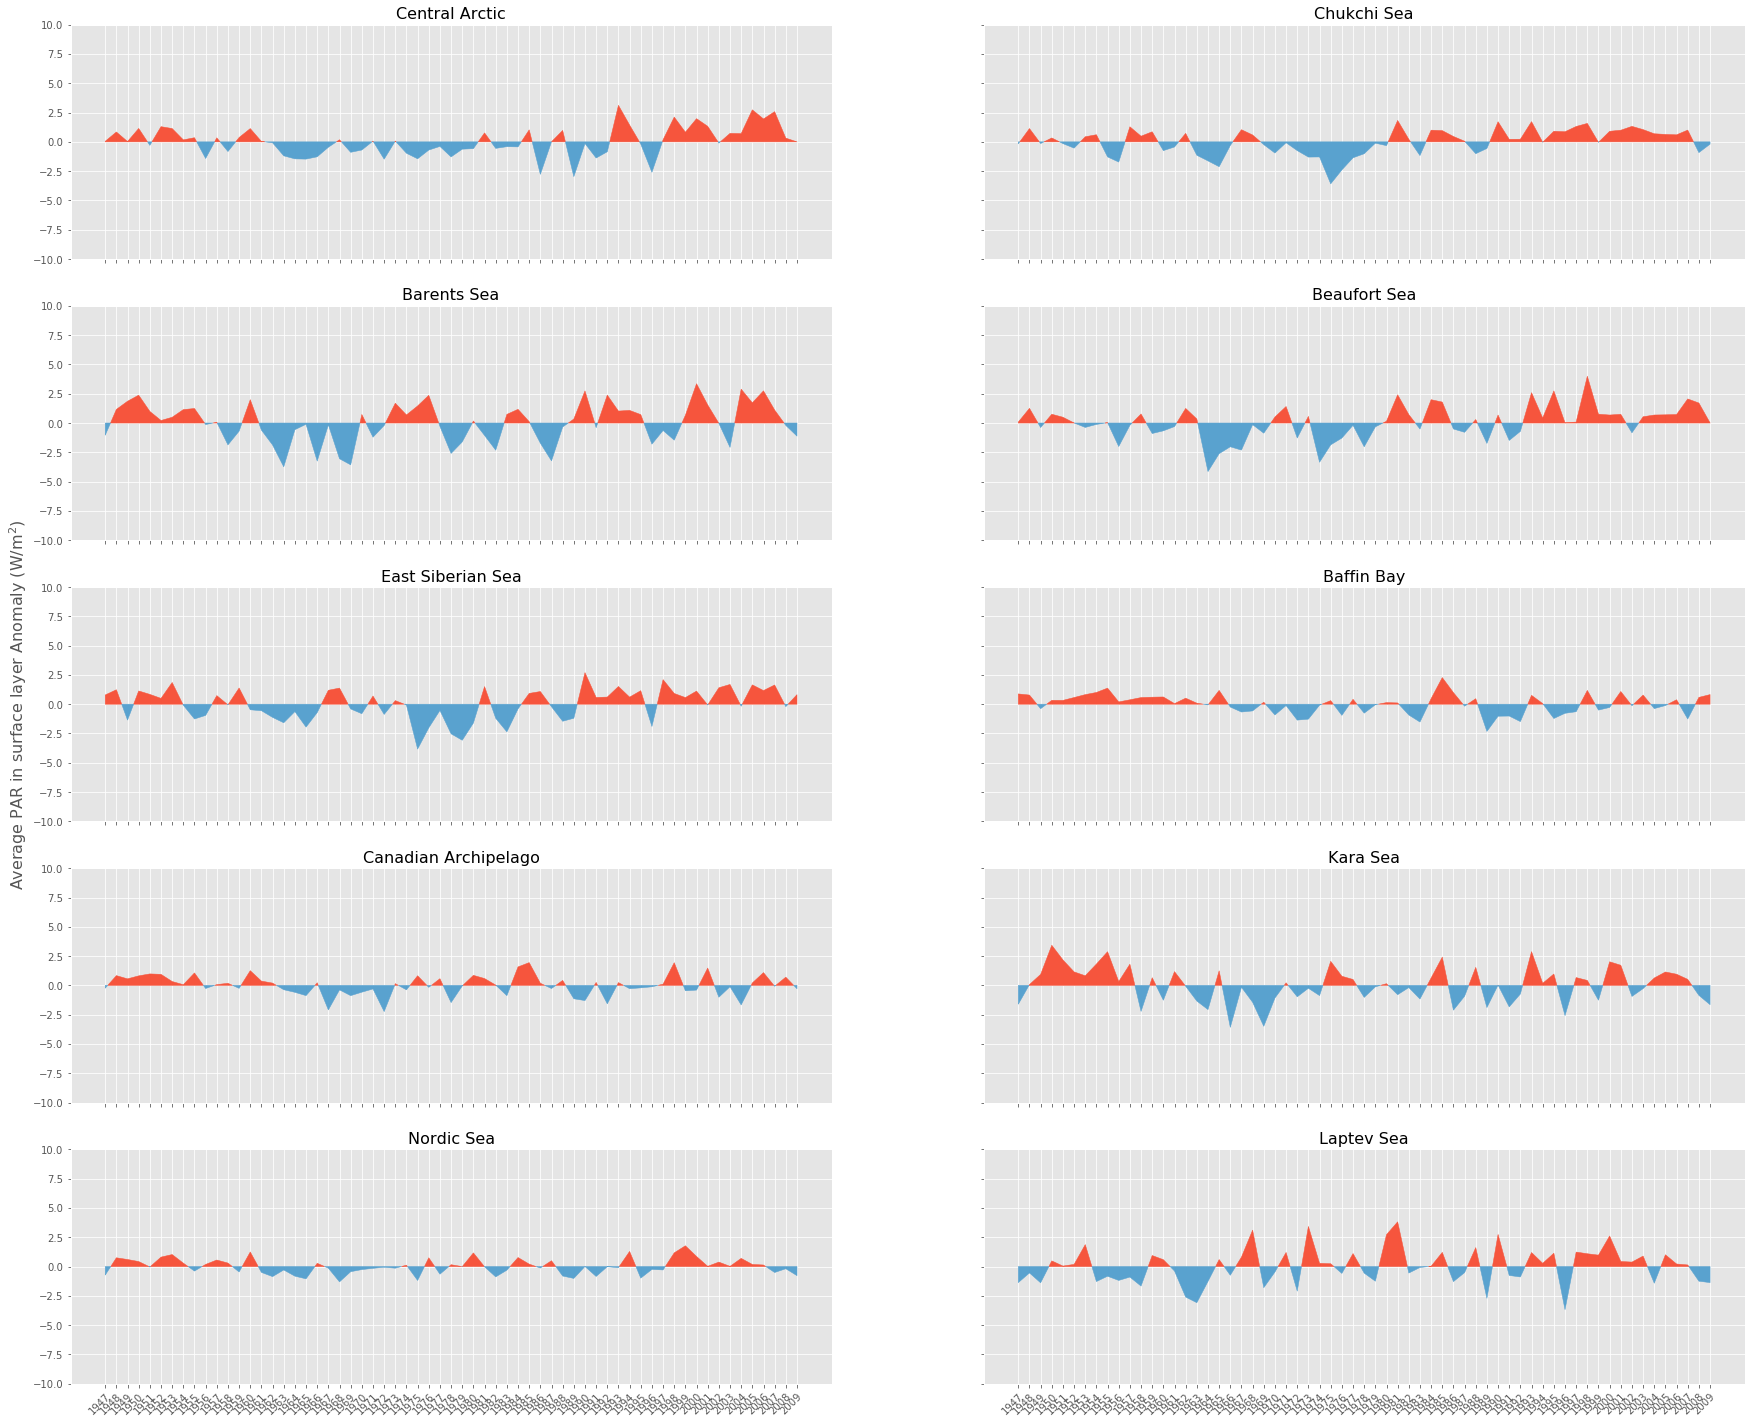

In [43]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(PAR_avg_ao_anom,axis=1), where=np.nanmean(PAR_avg_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(PAR_avg_ao_anom,axis=1), where=np.nanmean(PAR_avg_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16)

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(PAR_avg_bts_anom,axis=1), where=np.nanmean(PAR_avg_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(PAR_avg_bts_anom,axis=1), where=np.nanmean(PAR_avg_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16)

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(PAR_avg_cs_anom,axis=1), where=np.nanmean(PAR_avg_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(PAR_avg_cs_anom,axis=1), where=np.nanmean(PAR_avg_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(PAR_avg_ess_anom,axis=1), where=np.nanmean(PAR_avg_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(PAR_avg_ess_anom,axis=1), where=np.nanmean(PAR_avg_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_title('East Siberian Sea', fontsize=16)

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(PAR_avg_ca_anom,axis=1), where=np.nanmean(PAR_avg_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(PAR_avg_ca_anom,axis=1), where=np.nanmean(PAR_avg_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16)

ax6 = fig.add_subplot(gs[4, 0])
ax6.fill_between(years, np.nanmean(PAR_avg_ns_anom,axis=1), where=np.nanmean(PAR_avg_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(PAR_avg_ns_anom,axis=1), where=np.nanmean(PAR_avg_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16)
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(PAR_avg_bs_anom,axis=1), where=np.nanmean(PAR_avg_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(PAR_avg_bs_anom,axis=1), where=np.nanmean(PAR_avg_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(PAR_avg_bb_anom,axis=1), where=np.nanmean(PAR_avg_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(PAR_avg_bb_anom,axis=1), where=np.nanmean(PAR_avg_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(PAR_avg_ks_anom,axis=1), where=np.nanmean(PAR_avg_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(PAR_avg_ks_anom,axis=1), where=np.nanmean(PAR_avg_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(PAR_avg_ls_anom,axis=1), where=np.nanmean(PAR_avg_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(PAR_avg_ls_anom,axis=1), where=np.nanmean(PAR_avg_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Basics 
ax4.set_ylabel('Average PAR in surface layer Anomaly (W/m$^2$)', fontsize=16)
ax1.set_ylim(-10,10); ax1.set_xticklabels('')
ax2.set_ylim(-10,10); ax2.set_xticklabels('')
ax3.set_ylim(-10,10); ax3.set_yticklabels(''); ax3.set_xticklabels('')
ax4.set_ylim(-10,10); ax4.set_xticklabels('')
ax5.set_ylim(-10,10); ax5.set_xticklabels('')
ax6.set_ylim(-10,10);
ax7.set_ylim(-10,10); ax7.set_yticklabels(''); ax7.set_xticklabels('')
ax8.set_ylim(-10,10); ax8.set_yticklabels(''); ax8.set_xticklabels('')
ax9.set_ylim(-10,10); ax9.set_yticklabels(''); ax9.set_xticklabels('')
ax.set_ylim(-10,10);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/PAR_avg_anomaly',dpi=600, bbox_inches='tight')

plt.show()